In [198]:
# Initialize libraries and functions
# from numba import jit, cuda
import warnings
import cv2
import numpy as np
import math
import random
import time as timess
from prettytable import PrettyTable
from IPython.display import clear_output, Markdown, display
from abc import ABC, abstractmethod 

def db_to_normal(x):
    return 10**(x/10)

def normal_to_db(x):
    return 10*math.log10(x)

def pdw_tabular_print(pdw,time):
    if(len(pdw)>1):
        display(Markdown('{}<strong>{}</strong>{}'.format('PDW\'s of the recieved pulses in ',str(time//10)+' nano seconds',' are as follows')))
        t = PrettyTable(list(pdw[0].keys()))
        for i in pdw[:]:
            t.add_row(list(i.values()))
        print(t)

# base_noise_min=db_to_normal(-1000)
# base_noise_max=db_to_normal(-75)
base_noise_min=db_to_normal(-1000*1000)
base_noise_max=db_to_normal(-75*1000)
ci=0#len(time)//4
cf=10000
cf=10000
fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'
rand_skew=0

In [199]:
# Initiallize tables

# rf = open("Radar_G_table.txt", "w")
# f = open("RWR_G_table.txt", "w")
# for j in range(5,185,5):
#     f.write(str(j/10))
#     f.write(' | ')
#     rf.write(str(j/10))
#     rf.write(' | ')
#     for i in range(360):
#         if((i>=0 and i<=90) or (i>=270 and i<360)):
#             f.write(str(math.cos(math.radians(i)))+' ')
#             rf.write(str(math.cos(math.radians(i)))+' ')
#         else:
#             f.write(str(0)+' ')
#             rf.write(str(0)+' ')
#     f.write('\n')
#     rf.write('\n')
# f.close()    
# rf.close()  

# f = open("angle_table.txt", "w")
# for th in range(-45,45):
#     a1=round(normal_to_db(math.cos(math.radians(45+th))),4)
#     a2=round(normal_to_db(math.cos(math.radians(45-th))),4)
#     f.write(str(round(a2-a1,5))+',')
# th=45
# a1=round(normal_to_db(math.cos(math.radians(45+th))),4)
# a2=round(normal_to_db(math.cos(math.radians(45-th))),4)
# f.write(str(round(a2-a1,5)))
# f.close()


RWR_G_table={}
f = open("RWR_G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    RWR_G_table[tmp_freq]=[]
    for radar in tmp:
        RWR_G_table[tmp_freq].append(float(radar))
f.close()

Radar_G_table={}
f = open("Radar_G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    Radar_G_table[tmp_freq]=[]
    for radar in tmp:
        Radar_G_table[tmp_freq].append(float(radar))
f.close()

f = open("angle_table.txt", "r")
angle_table=tuple(map(float,f.read().split(',')))
f.close()

In [200]:
class battle_system(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def get(self):
        pass
        
    @abstractmethod
    def set(self):
        pass
        
    @abstractmethod
    def ontick(self):
        pass
    
    def __del__(self):
        pass

In [201]:
class platform(battle_system):
    def __init__(self, pos=(0,0),speed=0,onboard_systems=[]):
        super().__init__()
        self.position = pos
        self.speed = speed
        self.onboard_systems = onboard_systems
    
    def __del__(self):
        super().__del__()

In [202]:
  
class aircraft(platform):
    def __init__(self, id,heading=0,speed=10,aircraftWaypoints=[],onboard_systems=[]):
        super().__init__(aircraftWaypoints[0] ,speed,onboard_systems)
        self.id = id                                       # Id of the Aircraft
        self.heading = heading                             # heading of the Aircraft in degrees
        self.aircraftWaypoints=aircraftWaypoints
        self.next_waypoint=1
        
    def move_aircraft(self):
        if(len(self.aircraftWaypoints)>1):
            time_diff=1
            cur_pos=list(self.position)
            next_waypoint=self.next_waypoint
            d=math.dist(self.aircraftWaypoints[next_waypoint],cur_pos)
            idx=0
            while(d < (self.speed*time_diff)):
                idx += 1
                next_waypoint += 1
                if (next_waypoint== len(self.aircraftWaypoints)):
                    next_waypoint = 0
                if(idx>len(self.aircraftWaypoints)*2):
                    raise Exception("Aircraft speed is too much")
                d=math.dist(self.aircraftWaypoints[next_waypoint],cur_pos)
            heading=math.degrees(math.atan2(self.aircraftWaypoints[next_waypoint][1] - cur_pos[1],self.aircraftWaypoints[next_waypoint][0] - cur_pos[0]))
            while(heading>=360):
                heading-=360
            while(heading<0):
                heading+=360
            self.heading=heading
            cur_pos[0] += ((self.speed * time_diff) * (self.aircraftWaypoints[next_waypoint][0] - cur_pos[0]) / d)
            cur_pos[1] += ((self.speed * time_diff) * (self.aircraftWaypoints[next_waypoint][1] - cur_pos[1]) / d)
            self.position=cur_pos
            self.next_waypoint=next_waypoint

    def get(self):
        return self.position
        
    def set(self,speed):
        self.speed=speed
        
    def ontick(self):
        self.move_aircraft()
    
    def __del__(self):
        super().__del__()

In [203]:
class radar(battle_system):
    def __init__(self, id,pri=500,pwd=10,heading=0,radarWaypoints=[],signature_type='fixed'):
        super().__init__()
        self.id = id                                       # Id of the radar
        self.pri = pri                                     # Pulse Repetition Interval 1 nano seconds
        self.pwd = pwd                                     # Pulse Width in 1 nano seconds
        self.Pt = (10**4)*1                                # Peak transmitted power
        self.freq = 10.0                                   # frequency range 0.5 to 18 units gigahertz
        self.heading = heading                             # heading of the radar in degrees
        self.sig_data=list(signature_type.split(' '))
        self.signature_type=self.sig_data[0]
        self.impedance = 50
        self.position = radarWaypoints[0]
        self.speed=10
        self.radarWaypoints=radarWaypoints
        self.next_waypoint=1
        
    def move_radar(self):
        if(len(self.radarWaypoints)>1):
            time_diff=1
            cur_pos=list(self.position)
            next_waypoint=self.next_waypoint
            d=math.dist(self.radarWaypoints[next_waypoint],cur_pos)
            idx=0
            while(d < (self.speed*time_diff)):
                idx += 1
                next_waypoint += 1
                if (next_waypoint== len(self.radarWaypoints)):
                    next_waypoint = 0
                if(idx>len(self.radarWaypoints)*2):
                    raise Exception("Radar "+self.id+"'s speed is too much")
                d=math.dist(self.radarWaypoints[next_waypoint],cur_pos)
            heading=math.degrees(math.atan2(self.radarWaypoints[next_waypoint][1] - cur_pos[1],self.radarWaypoints[next_waypoint][0] - cur_pos[0]))
            while(heading>=360):
                heading-=360
            while(heading<0):
                heading+=360
            # self.heading=heading
            cur_pos[0] += ((self.speed * time_diff) * (self.radarWaypoints[next_waypoint][0] - cur_pos[0]) / d)
            cur_pos[1] += ((self.speed * time_diff) * (self.radarWaypoints[next_waypoint][1] - cur_pos[1]) / d)
            self.position=cur_pos
            self.next_waypoint=next_waypoint

    def get(self):
        return self.position
        
    def set(self,speed,heading):
        self.speed=speed
        self.heading=heading
        
    def ontick(self):
        self.move_radar()
    
    def __del__(self):
        super().__del__()

In [204]:
class sensor(battle_system):
    def __init__(self,host_platform):
        super().__init__()
        self.host_platform = host_platform
    
    def __del__(self):
        super().__del__()

In [205]:

class rwr(sensor):
    def __init__(self, number_of_antennas,host_platform):
        super().__init__(host_platform)
        self.number_of_antennas=number_of_antennas
        self.threats=[]
        self.pdws=[]
        self.emitter_records=[]
        
    def emitter_record_generator(self,radar):
        global RWR_G_table,Radar_G_table,base_noise_min,base_noise_max
        pri = radar.pri                               # Pulse Repetition Interval
        pwd = radar.pwd                               # Pulse Width
        R = math.dist(radar.position,self.host_platform.position)*100      # Distance between the radar and the aircraft
        Pt = radar.Pt                                 # Peak transmitted power
        freq = radar.freq                             # carrier frequency
        sig_data=radar.sig_data
        signature_type=radar.signature_type
        # Lambda=3*(10**8)/radar.freq
        Lambda=2
        angle=math.degrees(math.atan2(radar.position[1]-self.host_platform.position[1],radar.position[0]-self.host_platform.position[0]))-self.host_platform.heading
        while(angle>=360):
            angle-=360                                     # Angle between the aircraft's front direction and radar
        while(angle<0):
            angle+=360
        angle_rad = radar.heading
        angle_t=int(angle-angle_rad-180-(360-self.host_platform.heading))
        while(angle_t>=360):
            angle_t-=360                                     # Angle between the radar's boresight and aircraft
        while(angle_t<0):
            angle_t+=360
        P=(Pt*Radar_G_table[freq][angle_t]*(Lambda**2))/((4*math.pi*R)**2)  # Power recieved by the aircraft radar reciver
        tmp_v=abs(P*RWR_G_table[freq][0])
        tmp_n=random.uniform(base_noise_min,base_noise_max)
        if(tmp_v>base_noise_max):
            return [[radar.id,radar.freq,radar.pri]] if normal_to_db(tmp_v*1000)>-75 else []
        else:
            return []
    
    def emitter_records_generator(self,radars):
        global RWR_G_table,Radar_G_table,angle_table,base_noise_min,base_noise_max,time,receivers_n,rwr_antenna_n
        emitters=[]
        for j in range(len(radars)):
            emitters+=self.emitter_record_generator(radars[j])
        return emitters
        
    def signal_generator(self,radar,i):
        global RWR_G_table,Radar_G_table,angle_table,base_noise_min,base_noise_max,time,receivers_n,rwr_antenna_n,rand_skew
        pri = radar.pri                               # Pulse Repetition Interval
        pwd = radar.pwd                               # Pulse Width
        R = math.dist(radar.position,self.host_platform.position)*100      # Distance between the radar and the aircraft
        Pt = radar.Pt                                 # Peak transmitted power
        freq = radar.freq                             # carrier frequency
        sig_data=radar.sig_data
        signature_type=radar.signature_type
        # Lambda=3*(10**8)/radar.freq
        Lambda=2
        angle=math.degrees(math.atan2(radar.position[1]-self.host_platform.position[1],radar.position[0]-self.host_platform.position[0]))-self.host_platform.heading
        while(angle>=360):
            angle-=360                                     # Angle between the aircraft's front direction and radar
        while(angle<0):
            angle+=360
        angle_rad = radar.heading
        angle_t=int(angle-angle_rad-180-(360-self.host_platform.heading))
        while(angle_t>=360):
            angle_t-=360                                     # Angle between the radar's boresight and aircraft
        while(angle_t<0):
            angle_t+=360
        angle_radar = angle_t
        P=(Pt*Radar_G_table[freq][angle_t]*(Lambda**2))/((4*math.pi*R)**2)  # Power recieved by the aircraft radar reciver
        a=0.1
        omega=2*np.pi*18/10
        angl_cond=[]
        loss=8
        pulse_train_angles=[]
        pulse_train_frequency=[]
        pulse_train=[]                                   # we are producing the pulse train for the 4 recievers
        for j in range(receivers_n):                          # front left, rear left, rear right and front right respectively
            angl_cond.append((360/receivers_n)*(1+2*j)/2)     # based on the above information
            pulse_train.append([])
        for j in range(rwr_antenna_n-receivers_n):
            pulse_train.append([])
        # for i in range(-1,len(time)-1):
        if(signature_type=='skew'):
            if(i%pri==pri-pwd):
                rand_skew=int(random.uniform(-pwd//10,pwd//10))
            if(i%(pri+rand_skew)<=pwd):
                current_pulse=True
            else:
                current_pulse=False
        elif(signature_type=='jittered'):
            if(i%pri==pri-2*pwd):
                rand_skew=int(random.uniform(-pwd,pwd))
            if(i%(pri+rand_skew)<=pwd):
                current_pulse=True
            else:
                current_pulse=False
        elif(signature_type=='staggered'):
            if(len(sig_data)==3):
                n=int(sig_data[1])
                sub_pri=int(sig_data[2])
                while(n*sub_pri>pri):
                    n-=1
                for k in range(n):
                    if(i%pri>(sub_pri*k) and i%pri<=((sub_pri*k)+pwd)):
                        current_pulse=True
                        break
                    else:
                        current_pulse=False
            else:
                if(i%pri<=pwd):
                    current_pulse=True
                else:
                    current_pulse=False
        elif(signature_type=='switcher'):
            if(len(sig_data)>=3 and ((len(sig_data)-1)//2)%2==0):
                sets=[]
                total_pri=0
                for k in range((len(sig_data)-1)//2):
                    if k==0:
                        sets.append((int(sig_data[1+k*2])+1,int(sig_data[2+k*2])))
                        total_pri+=int(sig_data[1+k*2])*int(sig_data[2+k*2])
                    else:
                        sets.append((int(sig_data[1+k*2]),int(sig_data[2+k*2])))
                        total_pri+=int(sig_data[1+k*2])*int(sig_data[2+k*2])
                t_pri=0
                for k in range(len(sets)):
                    for l in range(sets[k][0]):
                        sub_pri=sets[k][1]
                        if(i%total_pri>(sub_pri*l+t_pri) and i%total_pri<=((sub_pri*l+t_pri)+pwd)):
                            # print(i,sub_pri*l,sub_pri*l+t_pri)
                            current_pulse=True
                            break
                        else:
                            current_pulse=False
                    if(l<sets[k][0]-1):
                        break
                    t_pri+=(sets[k][0]*sets[k][1])
        else:
            if(i%pri<=pwd):
                current_pulse=True
            else:
                current_pulse=False
        if(current_pulse):
            pulse_train_angles.append(angle)
            pulse_train_frequency.append(freq)
            idx=0
            for j in pulse_train:
                tmp_n=random.uniform(base_noise_min,base_noise_max)
                tmp_v=abs(P*RWR_G_table[freq][int(angle-angl_cond[idx])])
                tmp_f=tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1))
                j.append(tmp_f)
                idx+=1
        else:
            pulse_train_angles.append(0)
            pulse_train_frequency.append(0)
            for j in pulse_train:
                j.append(random.uniform(base_noise_min,base_noise_max))
        return pulse_train,pulse_train_angles,pulse_train_frequency
      
    def generate_pdw(self,radars,time,currentIteration): #in nano seconds 
        pulse_train_angles=[]
        pulse_train_frequency=[]
        pulse_train=[]
        pulse_train_f=[]
        for j in range(rwr_antenna_n):
            pulse_train.append([])
            for i in range(len(radars)):
                pulse_train[-1].append([])
            pulse_train_f.append([])
        mov_offset=0
        tmp_pdw={}
        pdw=[]
        counter=[]
        max_amplitude=[]
        list_init=[]
        fall_flag=[]
        lead_flag=[]
        increasing_count=[]
        increasing_flag=[]
        top_points=[]
        for j in range(rwr_antenna_n):
            counter.append(0)
            max_amplitude.append(0)
            increasing_count.append(0)
            list_init.append([])
            top_points.append([])
            increasing_flag.append(0)
            fall_flag.append(True)
            lead_flag.append(True)

        start_time=currentIteration*time
        idx=start_time
        time+=start_time
        
        while idx<time:
            airc_pos=(int(self.host_platform.position[0]),int(self.host_platform.position[1]))      
            #generating signals
            max_t=[]
            max_t_a=set()
            max_t_f=set()
            for j in range(rwr_antenna_n):
                max_t.append([])
            for j in range(len(radars)):
                radar_pos=(int(radars[j].position[0]),int(radars[j].position[1]))
                heading_angle=int(math.degrees(math.atan2(airc_pos[1]-radar_pos[1],airc_pos[0]-radar_pos[0])))#+180
                heading_noise_range=0
                # radars[j].heading=heading_angle#random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range)
                pulse_train_r,pulse_train_angles_r,pulse_train_frequency_r=self.signal_generator(radars[j],idx)
                for k in range(len(pulse_train_r)):
                    max_t[k].append(pulse_train_r[k][0])
                    pulse_train[k][j].append(pulse_train_r[k][0])
                if(pulse_train_angles_r[0]!=0):
                    max_t_a.add(pulse_train_angles_r[0])
                if(pulse_train_frequency_r[0]!=0):
                    max_t_f.add(pulse_train_frequency_r[0])
            
            # generating the pdw's
            if(len(max_t_a)==1):
                pulse_train_angles.append(list(max_t_a)[0])
            else:
                pulse_train_angles.append(0)
            if(len(max_t_a)==1):
                pulse_train_frequency.append(list(max_t_f)[0])
            else:
                pulse_train_frequency.append(0)
            all_fall=0
            tmp_counter=[]
            tmp_amplitude=[]
            for j in range(len(max_t)):
                pulse_train_f[j].append(max(max_t[j]))
                if(pulse_train_f[j][-1]>base_noise_max):
                    if(normal_to_db(pulse_train_f[j][-1]*1000)>-75):
                        if not(lead_flag[j]):
                            lead_flag[j]=True # Rising edge
                            if(len(tmp_pdw)==0):
                                tmp_pdw['TOA']=idx
                        if(pulse_train_f[j][-1]>max_amplitude[j]):
                            max_amplitude[j]=pulse_train_f[j][-1]
                        counter[j]+=1
                        fall_flag[j]=False
                    else:
                        if not(fall_flag[j]):
                            fall_flag[j]=True # Falling edge
                            tmp_counter.append(counter[j])
                        tmp_amplitude.append(max_amplitude[j])
                        lead_flag[j]=False
                        max_amplitude[j]=0
                        counter[j]=0
                        all_fall+=1
                else:
                    if not(fall_flag[j]):
                        fall_flag[j]=True # Falling edge
                        tmp_counter.append(counter[j])
                    tmp_amplitude.append(max_amplitude[j])
                    lead_flag[j]=False
                    max_amplitude[j]=0
                    counter[j]=0
                    all_fall+=1
            if(all_fall==len(max_t) and len(tmp_pdw)!=0):
                round_digits=2
                tmp_pdw['PWD']=max(tmp_counter)-1
                tmp_pdw['Frequency (GHz)']=round(max(pulse_train_frequency[tmp_pdw['TOA']-1-start_time:tmp_pdw['TOA']+tmp_pdw['PWD']-start_time]),2)
                tmp_pdw['Frequency (GHz)']=abs(round(tmp_pdw['Frequency (GHz)']+(random.uniform(-0.001,0.001) if tmp_pdw['Frequency (GHz)']>0 else 0),4))
                tmp_pdw['TOA']=tmp_pdw['TOA']+int(random.uniform(-10,10))
                amp_unit='dbm'
                amlitudes=[]
                for j in range(len(max_t)):
                    amp_value=tmp_amplitude[j]
                    # print(amp_value,idx)
                    # round(normal_to_db(amp_value),round_digits)
                    if(amp_value==0):
                        amp_value=0
                    else:
                        amp_value=normal_to_db(amp_value*1000)+85
                        # amp_value=normal_to_db(amp_value*1000)
                        amp_value=round(amp_value,5)
                        # if(amp_value<10):
                        #     amp_value=0
                    amlitudes.append(amp_value)
                    if(j==0):
                        tmp_pdw['A1 ('+str(amp_unit)+')']=(amp_value)
                    elif(j==1):
                        tmp_pdw['A2 ('+str(amp_unit)+')']=(amp_value)
                    elif(j==2):
                        tmp_pdw['A3 ('+str(amp_unit)+')']=(amp_value)
                    elif(j==3):
                        tmp_pdw['A4 ('+str(amp_unit)+')']=(amp_value)


                # tmp_pdw['AOA (Degrees)']=round(max(pulse_train_angles[tmp_pdw['TOA']:tmp_pdw['TOA']+tmp_pdw['PWD']]),round_digits)
                # tmp_pdw['AOA (Degrees)']=[]
                amp_ind=[]
                amp_cnt=0
                AOA=[]
                for amps in amlitudes:
                    amp_cnt+=1
                    if amps > 10:
                        amp_ind.append(amp_cnt)
                        # tmp_pdw[''].append((amps,amp_ind))
                        AOA.append(amps)
                if(len(amp_ind)==2):
                    if(amp_ind[0]==1 and amp_ind[1]==4):
                        t_ang=360-((np.abs(np.asarray(angle_table) - round(AOA[1]-AOA[0],round_digits))).argmin()-45)
                        if(t_ang>=360):
                            t_ang-=360
                        tmp_pdw['AOA (Degrees)']=t_ang
                    elif(amp_ind[0]==1 and amp_ind[1]==2):
                        tmp_pdw['AOA (Degrees)']=90+((np.abs(np.asarray(angle_table) - round(AOA[1]-AOA[0],round_digits))).argmin()-45)
                    elif(amp_ind[0]==2 and amp_ind[1]==3):
                        tmp_pdw['AOA (Degrees)']=180+((np.abs(np.asarray(angle_table) - round(AOA[1]-AOA[0],round_digits))).argmin()-45)
                    elif(amp_ind[0]==3 and amp_ind[1]==4):
                        tmp_pdw['AOA (Degrees)']=270+((np.abs(np.asarray(angle_table) - round(AOA[1]-AOA[0],round_digits))).argmin()-45)
                else:
                    tmp_pdw['AOA from table']=0
                tmp_pdw['Freq_mod_flag']=False
                pdw.append(tmp_pdw)
                tmp_pdw={}
            idx+=1
        return pdw,pulse_train_f,pulse_train

    def get(self):
        return self.pdws

    def ontick(self,radars=[],time=10**4,currentIteration=0):
        self.pdws=self.generate_pdw(radars,time,currentIteration)
        
    def set(self):
        pass
        
    # def get(self):
    #     return self.emitter_records

    # def ontick(self,radars=[]):
    #     self.emitter_records=self.emitter_records_generator(radars)
    
    def __del__(self):
        super().__del__()

In [206]:
# Initialization
rwr_antenna_n = 4              # Number of recievers on the aircraft(4 or 6)
radars_n = 3                   # Number of radars
receivers_n = 4 # Effective number of antenna

img = np.zeros((700,1400,3), np.uint8)

# Aircraft object is created
aircraft_waypoints = [(221, 469), 
                      (216, 174), 
                      (1237, 160), 
                      (1237, 478), 
                      (682, 650)]
aircraft_0 = aircraft(id=0,
                      heading=random.uniform(0,360),
                      speed=1,
                      aircraftWaypoints=aircraft_waypoints[:])

# RWR object is created

rwr_0 = rwr(number_of_antennas=receivers_n,host_platform=aircraft_0)
aircraft_0.onboard_systems=[rwr_0]

# RADAR object is created
radar_positions = np.array([
                            (655.0, 466.0),
                            (39.0, 300.0),
                            (50.0, 42.0),
                            (1355.0, 670.0),
                           ])
radar_waypoints = [[]]*len(radar_positions)
radar_waypoints = list([
                        # [radar_positions[0]]+[(829, 384), (505, 383)]
                        [radar_positions[1]]
                    #    ,[radar_positions[2]]
                    #    ,[radar_positions[3]]
                       ])
# radar_waypoints = list([[radar_positions[0]]])
radars_n=len(radar_waypoints)
radars=[]
#'fixed'
#'skew'
#'jittered'
#'staggered 2 100'
#'switcher'
# signatures=['fixed',
#             'fixed',
#             'fixed',
#             'fixed']
# signatures=['switcher 2 80 4 150']*radars_n
# signatures=['staggered 4 80']*radars_n
# signatures=['jittered']*radars_n
# signatures=['skew']*radars_n
signatures=['fixed']*radars_n
pris=[400,550,750,920]
for j in range(radars_n):
    heading_angle=int(math.degrees(math.atan2(aircraft_0.position[1]-radar_positions[j][1],aircraft_0.position[0]-radar_positions[j][0])))#+180
    heading_noise_range=0
    rand_pri=int(random.uniform(100,1000))
    radar_j = radar(id=j+1,pri=pris[j],pwd=15,
                    heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range),
                    radarWaypoints=radar_waypoints[j],
                    signature_type=signatures[j]
                   )
    rand_freq=(int(random.uniform(0,18)))
    radar_j.freq=0.5+rand_freq
    radars.append(radar_j)
    del radar_j;
    

print('Aircraft and it\'s description')
t = PrettyTable(['Id','Number of RWR antenna\'s'])
radar=aircraft_0
t.add_row([radar.id+1,radar.onboard_systems[0].number_of_antennas])
print(t)
print('Radars and their description')
t = PrettyTable(['Id', 'Peak transmitted power(db)','frequency (GHZ)','Pulse Repetition Interval(100 pico seconds)','Pulse Width(100 pico seconds)','signature_type'])
for radar in radars:
    t.add_row([radar.id,10*math.log10(radar.Pt),radar.freq,radar.pri,radar.pwd,radar.signature_type])
print(t)

Aircraft and it's description
+----+-------------------------+
| Id | Number of RWR antenna's |
+----+-------------------------+
| 1  |            4            |
+----+-------------------------+
Radars and their description
+----+----------------------------+-----------------+---------------------------------------------+-------------------------------+----------------+
| Id | Peak transmitted power(db) | frequency (GHZ) | Pulse Repetition Interval(100 pico seconds) | Pulse Width(100 pico seconds) | signature_type |
+----+----------------------------+-----------------+---------------------------------------------+-------------------------------+----------------+
| 1  |            40.0            |       12.5      |                     400                     |               15              |     fixed      |
+----+----------------------------+-----------------+---------------------------------------------+-------------------------------+----------------+


In [207]:
# Main Function


resize=1.2
cv2.namedWindow("Visualisation", cv2.WINDOW_NORMAL) 
cv2.resizeWindow("Visualisation", int(img.shape[1]/resize), int(img.shape[0]/resize))

tmp_s_r=20
tmp_s_a=20
aircraft_speed=1
radar_speed=1

time=10**3 #in 1 nano seconds 
play_flag=False
visualize=True
# for idx in range(60):
    # in_tim=timess.time()
idx=0
pdws=[]
pulse_train=[]
pulse_train_f=[]
for j in range(receivers_n):
    pulse_train.append([])
    for radar in range(len(radars)):
        pulse_train[-1].append([])
    pulse_train_f.append([])
age_in_PFM ={1:3,
             2:3,
             3:3,
             4:3}
age_out_PFM={1:3,
             2:3,
             3:5,
             4:3}
Emitter_Track_File={}
age_in={}
age_out={}
while(idx<500):
    print('tick number - ',str(idx+1))
    
    
    # ------------------------ get ----------------------------
    t_pos=aircraft_0.get()
    airc_pos=(int(t_pos[0]),int(t_pos[1]))

    radar_positions=[]
    for radar in radars:
        radar_positions.append(radar.get())

    for rwr in aircraft_0.onboard_systems:
        rwr_get = rwr.get() 
        if(len(rwr_get)>0):
            pdw=rwr_get[0]
            for j in range(receivers_n):
                pulse_train_f[j]+=rwr_get[1][j]
                for k in range(len(radars)):
                    pulse_train[j][k]+=rwr_get[2][j][k]
            pdws+=pdw
            pdw_tabular_print(pdw,time)

    # ------------------------ get ----------------------------


    # ------------------------ set ----------------------------
    aircraft_0.set(aircraft_speed)

    radar_i=0
    for radar in radars:
        radar_pos = radar_positions[radar_i]
        heading_angle=int(math.degrees(math.atan2(airc_pos[1]-radar_pos[1],airc_pos[0]-radar_pos[0])))#+180
        heading_noise_range=0
        Tracking = 0
        scan_speed = 1
        scan_direction = 1 # 1 for clockwise, -1 for counterclockwise
        if(Tracking):
            radar.set(radar_speed,random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range))
        else:
            radar.set(radar_speed,radar.heading+(scan_speed*scan_direction))
        radar_i+=1

    for rwr in aircraft_0.onboard_systems:
        rwr.set()
    
    # ------------------------ set ----------------------------

    # ------------------------ ontick ----------------------------
    aircraft_0.ontick()

    for radar in radars:
        radar.ontick()
    
    for rwr in aircraft_0.onboard_systems:
        rwr.ontick(radars,time,idx)
    # ------------------------ ontick ----------------------------
    
    # Visualization
    img = np.zeros(img.shape, np.uint8)
    for j in range(receivers_n):
        cv2.line(img, airc_pos, 
                 (int(airc_pos[0]+(tmp_s_a*math.cos(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2)))),
                  int(airc_pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2))))), (0,0,255), 2)
    cv2.circle(img, airc_pos, 5, (0,255,0), -1)
    airc_head=(int(airc_pos[0]+(tmp_s_a*1.5*math.cos(math.radians(aircraft_0.heading)))),int(airc_pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading)))))
    cv2.line(img, airc_pos, airc_head, (0,255,0), 2)
    for j in range(len(radars)):
        # adding the radars to the image
        radar_pos=(int(radars[j].position[0]),int(radars[j].position[1]))
        cv2.circle(img, radar_pos, 5, (255,0,0), -1)
        cv2.line(img, radar_pos, 
                 (int(radar_pos[0]+(tmp_s_r*math.cos(math.radians(radars[j].heading)))),
                  int(radar_pos[1]+(tmp_s_r*math.sin(math.radians(radars[j].heading))))), (0,0,255), 2)
    cv2.imshow('Visualisation',img)
    
    # quit_k = cv2.waitKey(1) & 0xFF
    # quit_k = cv2.waitKey(100) & 0xFF
    if(play_flag):
        quit_k = cv2.waitKey(1) & 0xFF
    else:
        quit_k = cv2.waitKey(0) & 0xFF
    clear_output(wait=True)
    if quit_k == ord('q'):
        break
    if quit_k == ord('p'):
        play_flag=False
    if quit_k == ord('l'):
        play_flag=True
    idx+=1
cv2.imwrite('Visualisation.jpg',img)
cv2.destroyAllWindows()

tick number -  284


In [208]:
# Display all PDW's
pdw_tabular_print(pdws,(idx+1)*time)

PDW's of the recieved pulses in <strong>28400 nano seconds</strong> are as follows

+--------+-----+-----------------+----------+----------+----------+----------+---------------+---------------+
|  TOA   | PWD | Frequency (GHz) | A1 (dbm) | A2 (dbm) | A3 (dbm) | A4 (dbm) | AOA (Degrees) | Freq_mod_flag |
+--------+-----+-----------------+----------+----------+----------+----------+---------------+---------------+
| 110402 |  15 |     12.4998     |    0     |    0     | 35.47387 | 38.44001 |      288      |     False     |
| 110804 |  15 |     12.5006     |    0     |    0     | 35.47387 | 38.44001 |      288      |     False     |
| 111208 |  15 |     12.5006     |    0     |    0     | 37.2484  | 40.21453 |      288      |     False     |
| 111606 |  15 |     12.4997     |    0     |    0     | 37.2484  | 40.21453 |      288      |     False     |
| 112402 |  15 |      12.499     |    0     |    0     | 38.51076 | 41.47689 |      288      |     False     |
| 112797 |  15 |     12.4996     |    0     |    0     | 38.51076 | 41.47689 |      288      |     False     |
|

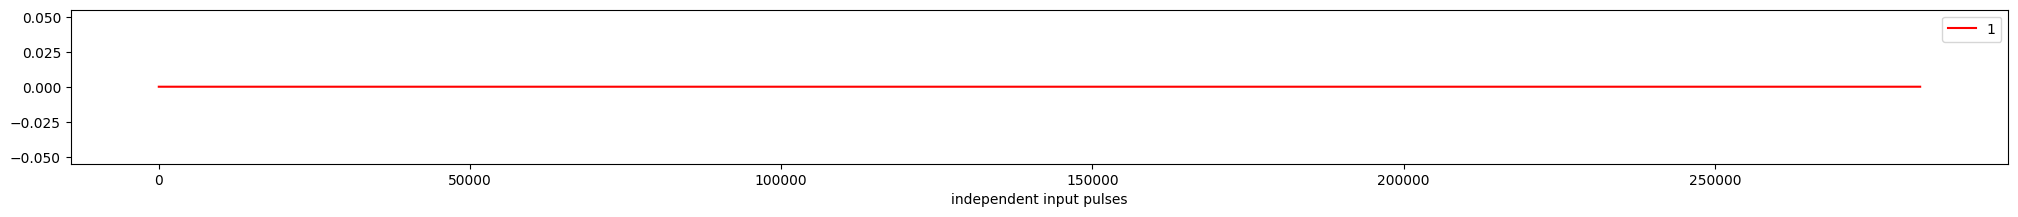

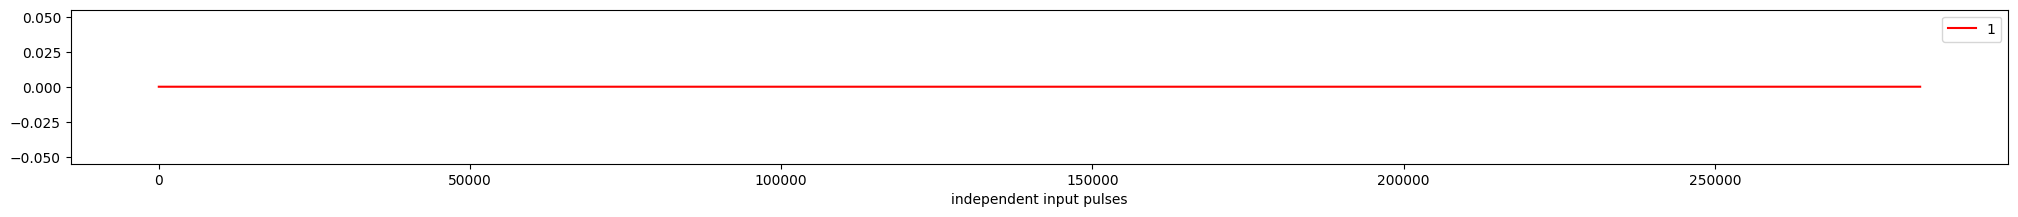

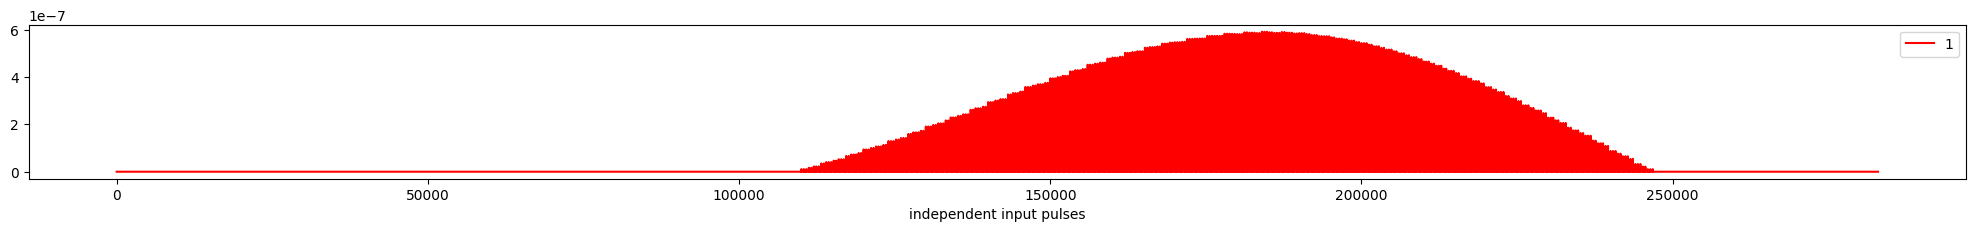

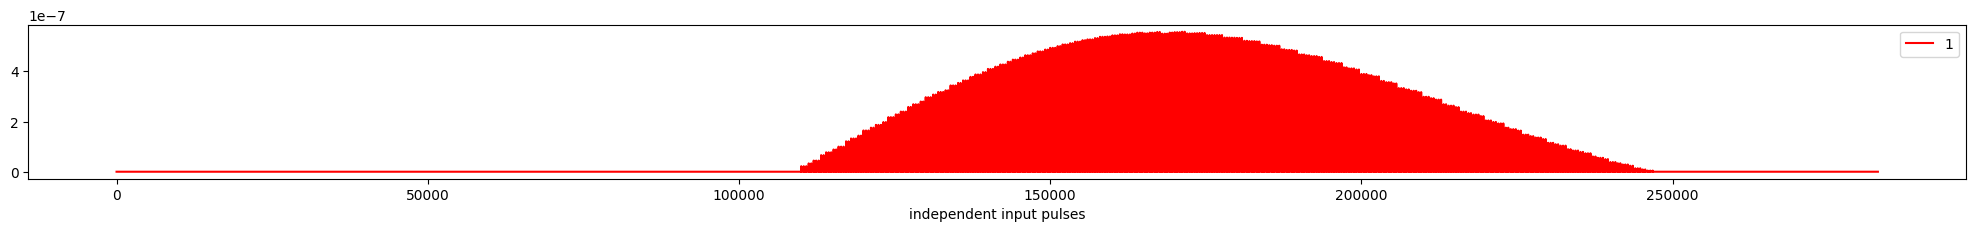

In [209]:
# Display independent Pulse Train 
import matplotlib.pyplot as plt

time_l=[*range(len(pulse_train_f[0]))]
ci=0#len(time)//4
cf=len(time_l)//1

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'

for radar in pulse_train:
    plt.figure(figsize=(fig_x , fig_y))
    jdx=0
    for j in radar:
        jdx+=1
        plt.plot(time_l[ci:cf],j[ci:cf], color=clrs[jdx-1], label=str(jdx))
    plt.legend()
    plt.xlabel("independent input pulses")
    # plt.ylim([0, ylim])
    # plt.savefig("independent"+str(jdx)+".jpg")
    plt.show()

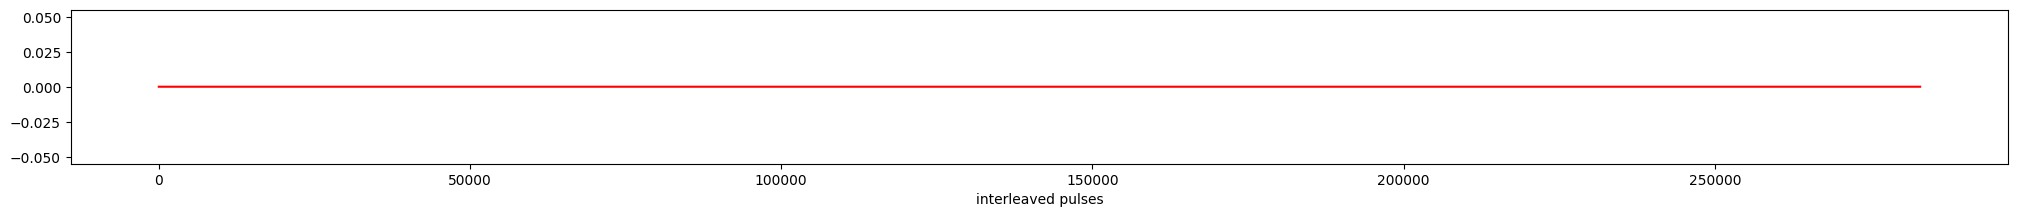

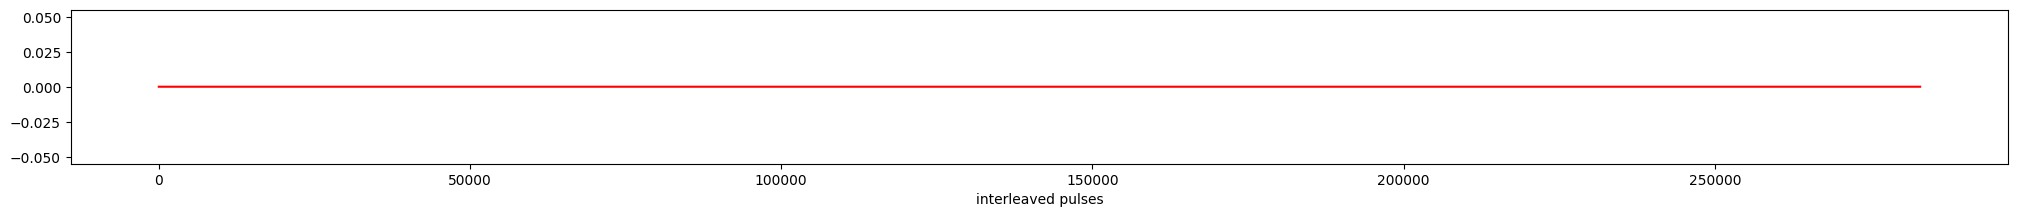

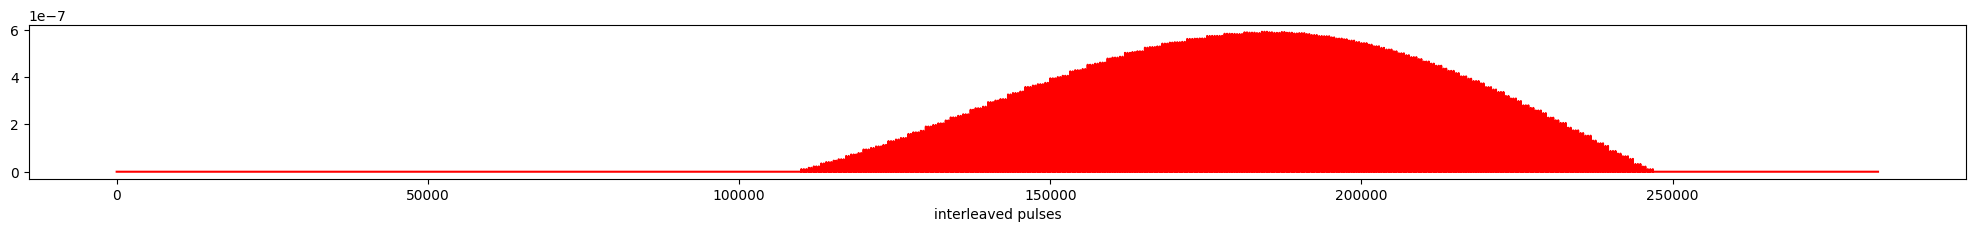

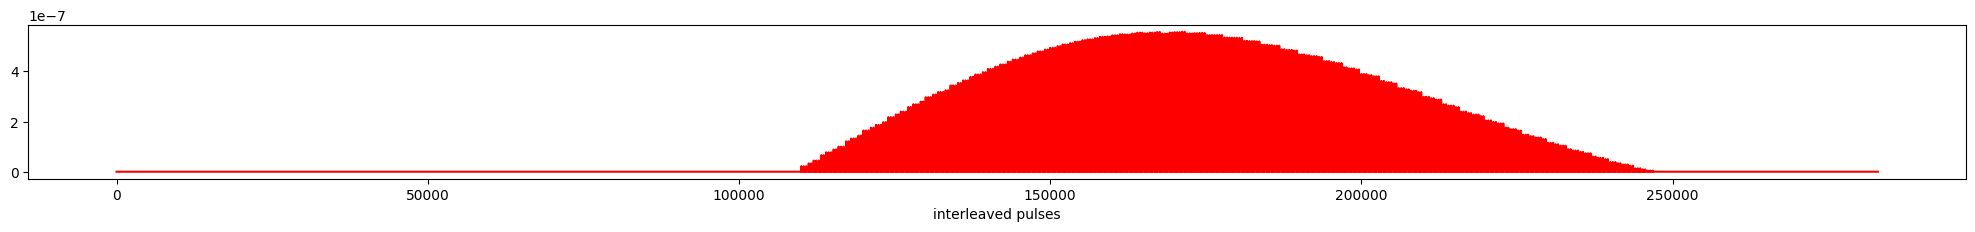

In [210]:
# Display interleaved Pulse Train

import matplotlib.pyplot as plt

time_l=[*range(len(pulse_train_f[0]))]
ci=0#len(time)//4
cf=len(time_l)//1

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'

# for i in pulse_train_f:
for radar in pulse_train_f:
    plt.figure(figsize=(fig_x , fig_y))
    plt.plot(time_l[ci:cf],radar[ci:cf], color=clrs[0]) 
    plt.xlabel("interleaved pulses")
    # plt.ylim([0, ylim])
    # plt.savefig("independent"+str(jdx)+".jpg")
    plt.show()

In [211]:
# Aircraft and radar waypoints
# def draw_rectangle(event,x,y,flags,param):
#     global pt_clicked
#     if event == cv2.EVENT_LBUTTONDOWN:
#         pt1 = (x,y)
#         pt_clicked.append(pt1)
#         cv2.circle(frame, center=pt1, radius=5, color=(0,0,255), thickness=-1)

# cv2.namedWindow('Test')
# cv2.setMouseCallback('Test', draw_rectangle) 

# pt_clicked=[]

# frame = np.zeros(img.shape, np.uint8)
# while True:
#     for i in radars:
#         radar_pos=(int(i.position[0]),int(i.position[1]))
#         heading_angle=int(math.degrees(math.atan2(airc_pos[1]-radar_pos[1],airc_pos[0]-radar_pos[0])))#+180
#         heading_noise_range=0
#         i.heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range)
#         cv2.circle(frame, radar_pos, 5, (255,0,0), -1)
#         cv2.line(frame, radar_pos, 
#                  (int(radar_pos[0]+(tmp_s_r*math.cos(math.radians(i.heading)))),
#                   int(radar_pos[1]+(tmp_s_r*math.sin(math.radians(i.heading))))), (0,0,255), 2)
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         print(pt_clicked)
#         break
#     if qk == ord('r'):
#         pt_clicked=[]
#         frame = np.zeros(img.shape, np.uint8)
#     if qk == ord('s'):
#         print(pt_clicked)
# cv2.destroyAllWindows()

In [212]:
# Radar coordinates
# def draw_rectangle(event,x,y,flags,param):
#     global pt_clicked
#     if event == cv2.EVENT_LBUTTONDOWN:
#         pt1 = (float(x),float(y))
#         pt_clicked.append(pt1)
#         cv2.circle(frame, center=(int(pt1[0]),int(pt1[1])), radius=5, color=(0,0,255), thickness=-1)

# cv2.namedWindow('Test')
# cv2.setMouseCallback('Test', draw_rectangle) 

# pt_clicked=[]

# frame = np.zeros(img.shape, np.uint8)
# while True:
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         print(pt_clicked)
#         break
#     if qk == ord('r'):
#         pt_clicked=[]
#         frame = np.zeros(img.shape, np.uint8)
#     if qk == ord('s'):
#         print(pt_clicked)
# cv2.destroyAllWindows()

In [213]:
# frame = np.zeros((500,2000,3), np.uint8)
# while True:
#     cv2.imshow('Test', frame)
#     qk=cv2.waitKey(1) & 0xFF
#     if qk == ord('q'):
#         break
# cv2.destroyAllWindows()